In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Define any random function
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
#function value for specific x
f(3)

20

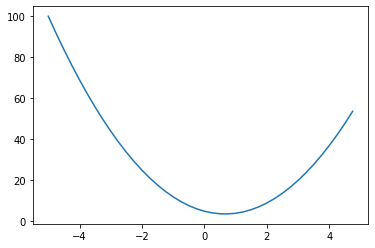

In [5]:
#plot function with generated xs
xs=np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
#calculate derivative for specific x
h=0.001
x=3.0
(f(x+h)-f(x))/h

14.00300000000243

In [8]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [10]:
h=0.0001
#inputs
a=2.0
b=-3.0
c=10.0

d1=a*b+c
#chose a,b or c for the variable needed slope
c+=h
d2=a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [141]:
#define Value class

class Value:
    def __init__(self, data, _children=(),_op='', label=''):
        self.data = data
        self.grad=0.0
        self._backward=lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad+=1.0 * out.grad
            other.grad+=1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other),'*')
        
        def _backward():
            self.grad +=other.data*out.grad
            other.grad+=self.data*out.grad
        
        out._backward=_backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward=_backward
        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        #go through topological graph in reverse order, from right to left
        for node in reversed(topo):
            node._backward()
    
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')
e = a*b; e.label= 'e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f
L;L.label='L'

In [122]:
#values
d._prev

{Value(data=-6), Value(data=10)}

In [43]:
#operation on values
d._op

'+'

In [47]:
#visualization
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

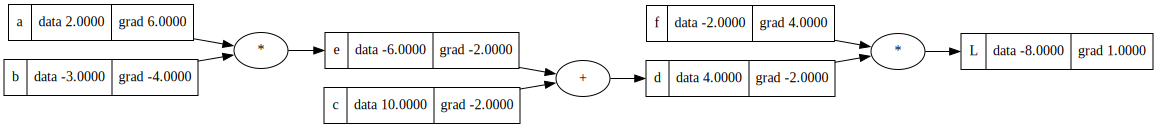

In [61]:
draw_dot(L)

In [63]:
#example function to calculate the partial derivative
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  #a.data+=h
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  #c.data +=h
  e = a*b; e.label = 'e'
  #e.data+=h
  d = e + c; d.label = 'd'
  #d.data+=h
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


In [50]:
#calculate the partial derivatives of L manually

d.grad=-2.0
f.grad=4.0
L.grad=1.0

In [55]:
#dL/dc  = dd/dc
#d=c+e -> dd/dc = dd/de = 1.0

#we want dL/dc = dL/dd * dd/dc
#we know dL/dd, dd/dc

c.grad = -2.0
e.grad = -2.0

In [60]:
#dL/de=-2.0

#e=a*b
#we want dL/da = dL/de * de/da
a.grad=(-2.0*-3.0)
b.grad=-2.0*2.0

In [64]:
#how one step of optimization can look like
#we know how to influence the outcome L by knowing the gradients for each node
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-7.286496


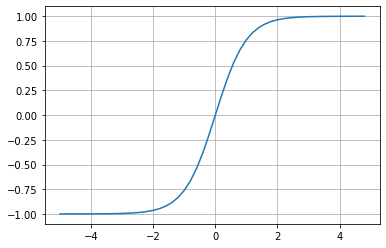

In [65]:
#example for an activation function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [135]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

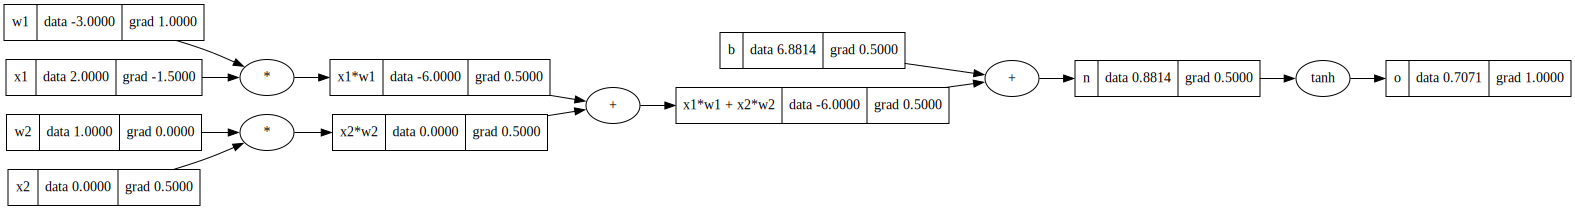

In [138]:
draw_dot(o)

In [75]:
#calculate the gradients manually
o.grad=1.0

In [76]:
#o=tanh(n)
#do/dn=1-tanh(n)**2 = 1-o**2
1-o.data**2
n.grad=0.5

In [82]:
#because of addition n.grad is distributed to x1w1x2w2 and b
x1w1x2w2.grad=0.5
b.grad=0.5

In [84]:
#same for x1w1 and x2w2 are 0.5
x1w1.grad=0.5
x2w2.grad=0.5

In [86]:
x2.grad=w2.data*x2w2.grad
w2.grad=x2.data*x2w2.grad

In [88]:
x1.grad = w1.data*x1w1.grad
w1.grad=x1.data*x1w1.grad

In [103]:
#calculate gradients via implemented backward function in class Value
o.grad=1.0
o._backward()

In [104]:
n._backward()

In [105]:
b._backward()

In [106]:
x1w1x2w2._backward()

In [107]:
x2w2._backward()

In [109]:
x1w1._backward()

In [111]:
#build a topological sort, all nodes from left to right
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [114]:
#instead of calling backward function for each node we will use a topological graph instead
o.grad=1.0
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

#go through topological graph in reverse order, from right to left
for node in reversed(topo):
    node._backward()

In [137]:
#use backward function for all nodes implemented in class Value
o.backward()

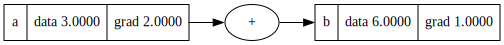

In [142]:

a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

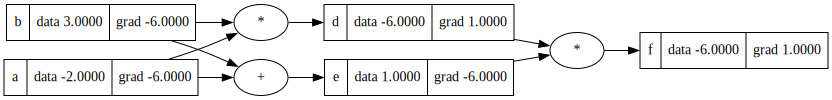

In [140]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)